<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Predicting housing prices with Regression

# Overview
Purchasing a house is a big decision for both investors and those looking for a place to stay. One of the key considerations behind this decision is the price of the property is reasonable.

**Goal**
To build an accurate model to predict the expected sale price of a house in Ames. The key metric used will be root mean squared error.

**Methods:<br/>**
1. Background Research on known factors which affect house sale prices
2. Data cleaning and exploration
    - Check and process NA values to
    - Check for obvious issues with data (e.g. continuous values within range and categorical values in their categories.
    - Check if categories are meaningful (ie. poor features result in poor prices) and convert ordinal features to continuous where appropriate.
    - Explore continuous variables to see general trends and correlations. Perform transformation where necessary to fit a linear relationship.
    - Delete features where there is very low variation between levels/categories.
    - Delete clear outliers.
3. Analysis
    - Use Linear Regression and regularisation techniques(Lasso, Ridge and ElasticNet) to build a home saleprice prediction model.
    - Accuracy of the model will be determined through cross validation, mean squared error (mse) and root mean squared error (rmse) scores. Models with a lower mse and rmse are more accurate.
    - Variables which perform poorly at each stage (heavily penalised during Lasso Regression) will be considered for removal before new variables are added in the subsequent stage.

# Background Research

According to online sources, home sale prices in the USA are affected by factors including:<br/>
**Macro**
1. Economy, market cycles
2. Tax rates
3. Local housing market
4. Supply and demand (e.g. bidding wars)
5. Government laws
6. Comparable sales

**Home Related**
1. Location, neighborhood, nearby features
2. Home size, layout
3. Home age
4. Property condition
5. Presentation and pricing strategy

While the macroeconomic influences on the house prices are good to know, it is not possible to control or predict. However, we can use most of the home related factors which are available in the dataset to make our predictions. These factors and the like will be included in our analysis.

([*source 1*](https://www.opendoor.com/w/blog/factors-that-influence-home-value))
([*source 2*](https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/))
([*source 3*](https://www.newrez.com/blog/home-buying-selling/5-things-that-influence-home-prices-in-2021/))
([*source 4*](https://www.homelight.com/blog/real-estate-property-value/))

In [8]:
# Import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler
)

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    RidgeCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV
    )

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
    )

from sklearn.metrics import (
    mean_squared_error)

In [789]:
# Import Data

train_original = pd.read_csv('datasets/train.csv')
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [790]:
# Standardise column names
new_col_names = [x.replace(" ", "_").lower() for x in list(train.columns)]
train.columns = new_col_names

In [791]:
#Getting a high level overview of the data
train.info()
train.shape
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# Data Cleaning and Exploration
This section includes:
1. Exploring features with explicit null values
2. Data Cleaning
    - Continuous features
    - Categorical features

## Exploring features with explicit null values

Data points that are not required will be removed (ie. homes in bad condition) and features with null values will be explored. To retain rows as much as possible and recode nulls to a new category.

In [792]:
train.isnull().sum().sort_values(ascending=False).head(30) #

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
mo_sold              0
sale_type            0
full_bath            0
half_bath            0
dtype: int64

#### Cleaning features with multiple explicit NAs

In [793]:
# View pool values
train.groupby('pool_qc', dropna=False)['pool_area'].count()

pool_qc
Ex        1
Fa        2
Gd        4
TA        2
NaN    2042
Name: pool_area, dtype: int64

In [794]:
# Clean pool values
train.drop('pool_qc', axis = 1, inplace = True)           # remove pool QC as counts are low
                                                          # few homes with pool
    
train['pool_area'] = [ x if x == 0 else 1 for x in train['pool_area']] 
                                                          # convert Pool Area to binary variable
                                                          # representing pool or no pool
train.rename(columns={"pool_area": "pool"}, inplace=True)
                                                          # rename pool_area to pool

In [795]:
# View misc_feature
train['misc_feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: misc_feature, dtype: int64

In [796]:
# Clean misc_feature
train.drop('misc_feature', axis=1, inplace=True) # random features with low counts
                                                 # to remove

In [797]:
# View alley values
train.groupby('alley', dropna=False)[['alley', 'saleprice']].count()

,alley,saleprice
alley,,
Grvl,85,85
Pave,55,55
NaN,0,1911


In [798]:
# Clean alley values
train['alley'].fillna('no_alley', inplace=True) # fill Alley NA with "No Alley"

In [799]:
# View fence values
train.groupby('fence', dropna=False)[['fence', 'saleprice']].count()

,fence,saleprice
fence,,
GdPrv,83,83
GdWo,80,80
MnPrv,227,227
MnWw,10,10
NaN,0,1651


In [800]:
# Clean fence values
train['fence'].fillna('no_fence', inplace=True) # fill fence NA with "no_Fence"

In [801]:
# View fireplace_qu values
train.groupby('fireplace_qu', dropna=False)['fireplaces'].count()
                            # all fireplace_qu NA have 0 fireplaces

fireplace_qu
Ex       31
Fa       59
Gd      523
Po       31
TA      407
NaN    1000
Name: fireplaces, dtype: int64

In [802]:
# Clean freplace_qu values
train['fireplace_qu'].fillna('non', inplace=True) # fill fireplace_qu NA with "no_fireplace"

In [803]:
# View mas_vnr NA values
train.loc[train['mas_vnr_type'].isnull(), ['mas_vnr_type', 'mas_vnr_area']].shape


(22, 2)

In [804]:
# Clean mas_vnr values
train.fillna({
    'mas_vnr_type' : 'non', # fill NA with 'no_mas'
    'mas_vnr_area' : 0,  # fill NA with '0
}, inplace=True) 

330

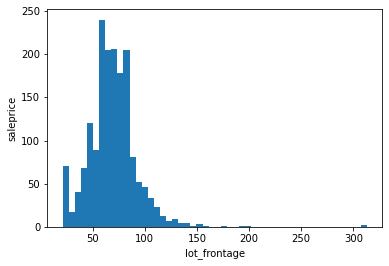

In [805]:
# View lot_frontage
#train['lot_frontage'].hist(bins=50)
plt.hist(train['lot_frontage'], bins=50)
plt.ylabel('saleprice')
plt.xlabel('lot_frontage');
train['lot_frontage'].isnull().sum()

In [806]:
# Clean lot_frontage
train['lot_frontage'].fillna(0, inplace=True)
                        # likely represents homes with no front
                        # noted that fillna 0 will cause a spike at 0

                        # outlier noticed where lot_frontage > 300
                        # to further assess during eda below

In [807]:
# View garage NA values
garage_col = [col for col in list(train.columns) if 'garage' in col] # retrieve garage related variables
garage_na = train.loc[train['garage_finish'].isnull(), garage_col] # Dataframe with Garage NAs
train[garage_col].isnull().sum() == garage_na.isnull().sum() # check that our sub-df is getting all NAs in Garage

train[garage_col].dtypes # view data types
                         # data types correspond to data dictionary

garage_na.isnull().sum() # view garage NAs

garage_type      113
garage_yr_blt    114
garage_finish    114
garage_cars        1
garage_area        1
garage_qual      114
garage_cond      114
dtype: int64

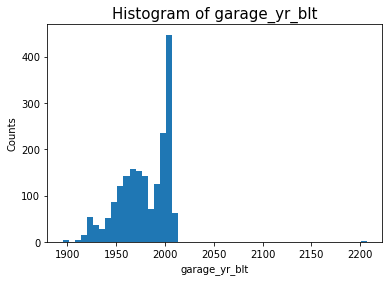

In [808]:
# View garage_yr_blt
plt.hist(train['garage_yr_blt'], bins=50)
plt.ylabel('Counts')
plt.xlabel('garage_yr_blt')
plt.title('Histogram of garage_yr_blt', fontsize=15);




In [809]:
# View garage_yr_blt - errorneous value
train[train['garage_yr_blt']>2010]['garage_yr_blt']             # only 1 errorneous value
train[train['garage_yr_blt']==2207][['year_built', 'yr_sold']]  # assess possible replacements
                                                                # since house built 2006 and sold 2007,
                                                                # fill garage_yr_blt as 2006
train.loc[train['garage_yr_blt']==2207, 'garage_yr_blt']=2006 

106065.99122807017
118341.0


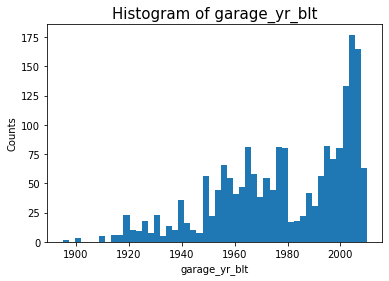

In [810]:
# View garage_yr_blt - homes with no garage
# to fill with reasonable year
plt.hist(train['garage_yr_blt'], bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('garage_yr_blt')
plt.title('Histogram of garage_yr_blt', fontsize=15);

print(train.loc[train['garage_yr_blt'].isnull(),:]['saleprice'].mean())
print(train.loc[(train['garage_yr_blt']>1905) & (train['garage_yr_blt']<1915),
                :]['saleprice'].mean())   # mean similar to above

train['garage_yr_blt'] = train['garage_yr_blt'].fillna(1910)          # fill garage_yr_blt with 1910


In [811]:
# Clean garage NA values
# For Index 1712, feature 'Garage Type', edit NA to 'no_Garage'
# For all other Garage features, edit to 'no_garage' or 0

train.loc[(train['garage_area'].isnull()) & 
          (train['garage_type'] == 'Detchd'), 'garage_type'] = np.nan

train.fillna({
    'garage_type':'non',
    'garage_finish':'non',
    'garage_qual':'non',
    'garage_cond':'non',
    'garage_cars' : 0,
    'garage_area' : 0
}, inplace=True)


In [812]:
# View Bsmt NA values
bsmt_col = [col for col in list(train.columns) if 'bsmt' in col] # retrieve Bsmt related variables
bsmt_na = train.loc[((train['bsmt_exposure'].isnull()) | 
                    (train['bsmtfin_type_2'].isnull())), bsmt_col] # df with Bsmt NAs

train[bsmt_col].isnull().sum() == bsmt_na.isnull().sum()  # check that our sliced dataframe is
                                                          # getting all NAs in Bsmt variables from main df

train[bsmt_col].dtypes # view data types
                       # data types correspond to data dictionary
bsmt_na.isnull().sum() # df with Garage NAs

bsmt_qual         55
bsmt_cond         55
bsmt_exposure     58
bsmtfin_type_1    55
bsmtfin_sf_1       1
bsmtfin_type_2    56
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
bsmt_full_bath     2
bsmt_half_bath     2
dtype: int64

In [813]:
# View Bsmt NA values
bsmt_na.loc[bsmt_na['bsmt_qual'].notnull(),:]   
                        # Deductive imputation performed for Index 1147, col bsmtfin_type_2
                        # change cell from NA to Unf

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1147,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


In [814]:
# View Bsmt NA values
train.groupby(['bsmt_qual', 'bsmt_cond', 'bsmt_exposure'])\
    ['bsmt_exposure'].count()

                                # Deductive imputation for Bsmt Exposure
                                # Most common value for 'Bsmt Qual' == 'Gd' and 'Bsmt Cond' == 'TA' 
                                # is 'No'

bsmt_qual  bsmt_cond  bsmt_exposure
Ex         Gd         Av                 4
                      Gd                 3
                      Mn                 1
                      No                12
           Po         No                 1
           TA         Av                37
                      Gd                66
                      Mn                14
                      No                46
Fa         Fa         Mn                 2
                      No                12
           Gd         Mn                 1
                      No                 1
           Po         Gd                 1
                      No                 2
           TA         Gd                 1
                      Mn                 5
                      No                35
Gd         Ex         Mn                 1
           Fa         Mn                 1
                      No                 2
           Gd         Av                 8
                  

In [815]:
# View Bsmt NA values
# For Index- 1147, feature 'BsmtFun Type 2', edit np.nan to 'Unf'
# For Index [1156, 1547, 1997], feature 'Bsmt Exposure', edit np.nan to 'No'
# For all other Bsmt features, edit to 'no_bsmt' or 0

train.loc[1147, 'bsmtfin_type_2'] = 'Unf'
train.loc[[1456, 1547, 1997], 'bsmt_exposure'] = 'No'

train.fillna({
    'bsmt_qual':'non',
    'bsmt_cond':'non',
    'bsmt_exposure':'non',
    'bsmtfin_type_1':'non',
    'bsmtfin_sf_1' : 0,
    'bsmtfin_type_2' : 'non',
    'bsmtfin_sf_2' : 0,
    'bsmt_unf_sf' : 0,
    'total_bsmt_sf' : 0,
    'bsmt_full_bath' : 0,
    'bsmt_half_bath' : 0,  
}, inplace=True)

In [816]:
#check that there are no more NAs
train.isnull().sum()

id              0
pid             0
ms_subclass     0
ms_zoning       0
lot_frontage    0
               ..
misc_val        0
mo_sold         0
yr_sold         0
sale_type       0
saleprice       0
Length: 79, dtype: int64

In [817]:
# change year_built and garage_yr_blt to age

train['garage_yr_blt'] = 2010 - train['garage_yr_blt']
train['year_built'] = 2010 - train['year_built']

# rename columns
train.rename(columns={"garage_yr_blt": "garage_age", "year_built": "house_age"}, inplace=True)

## Data Cleaning

1. Split dataset into those classified as numeric and categorical.
2. Ensure that numeric data is intended to be numeric according to data dictionary.
3. Ensure that categorical/ordinal data is correct according to data dictionary. Convert ordinal to continuous where reasonable.
4. To further clean or remove odd features

### Continuous Features

In [818]:
# create function to convery ordinal scales to continuous
def ordto_con(category):
    if type(category) == str:
        if category == 'non':
            return 0
        elif category == 'Po':
            return 1
        elif category == 'Fa':
            return 2
        elif category ==  'TA':
            return 3
        elif category == 'Gd':
            return 4
        elif category == 'Ex':
            return 5
        else:
            return np.nan
    else:
        return category

In [819]:
# reference point for number of numeric and categorical features at the start
num_features = train.select_dtypes([np.number])
cat_features = train.select_dtypes(include='object')
print(num_features.shape)
print(cat_features.shape)

(2051, 39)
(2051, 40)


In [820]:
# exploration of numeric features slice 1
num_features.iloc[:,:8].describe()


,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,house_age
count,2051.000000,2.051000e+03,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,57.944417,10065.208191,6.112140,5.562165,38.291078
std,843.980841,1.886918e+08,42.824223,33.137332,6742.488909,1.426271,1.104497,30.177889
min,1.000000,5.263011e+08,20.000000,0.000000,1300.000000,1.000000,1.000000,0.000000
25%,753.500000,5.284581e+08,20.000000,43.500000,7500.000000,5.000000,5.000000,9.000000
50%,1486.000000,5.354532e+08,50.000000,63.000000,9430.000000,6.000000,5.000000,36.000000
75%,2198.000000,9.071801e+08,70.000000,78.000000,11513.500000,7.000000,6.000000,56.500000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,138.000000


In [821]:
# Most variables of known range are correct(e.g. overall_qual)

# to remove 'id number' type variables
# recategorise wrongly classified variable (ms_subclass)

# id to remove
# pid to remove
train.drop(['pid', 'id'], axis=1, inplace=True)

# ms_subclass to change to categorical
train['ms_subclass'] = train['ms_subclass'].astype(str)

In [822]:
# exploration of numeric features slice 2
num_features.iloc[:,8:16].describe() 
                                        # 2nd_flr_sf, low_qual_fin_sf and bsmt_full_bath
                                        # have 0 at min, 25% and 50%
                                        # these variables likely have low counts 
                                        # (e.g. few homes with low quality finish
                                        # to kiv and assess again during eda

,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1984.190151,98.626524,442.084837,47.935641,567.451487,1057.471965,1164.488055,329.329108
std,21.036250,174.324690,461.195041,164.964052,445.022846,449.908003,396.446923,425.671046
min,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000
25%,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000
50%,1993.000000,0.000000,368.000000,0.000000,474.000000,994.000000,1093.000000,0.000000
75%,2004.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1405.000000,692.500000
max,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000


In [823]:
# exploration of numeric features slice 3
num_features.iloc[:,16:24].describe()
                                        # bsmt_half_bath and full_bath
                                        # have 0 at min, 25% and 50%
                                        # these variables likely have low counts
            
                                        # kitchen_abvgr and fireplaces
                                        # appear to have low variation
                                        # (e.g. kitchen_abvgr have same value at 25%, 50% and 75%)
                                        # to kiv and assess again during eda

,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,5.512921,1499.330083,0.427109,0.063384,1.577279,0.371039,2.843491,1.042906
std,51.068870,500.447829,0.522589,0.251590,0.549279,0.501043,0.826618,0.209790
min,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000
50%,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000
75%,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000
max,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000


In [824]:
# exploration of numeric features slice 3
num_features.iloc[:,24:32].describe()
                                        # wood_deck_sf, enclosed_porch, 3ssn_porch and screen_porch
                                        # appear to have similar issues
                                        # 0 at min, 25%, 50% and 75%
                                        # consider to remove, assess again during eda

,totrms_abvgrd,fireplaces,garage_age,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,6.435885,0.590931,35.209166,1.775719,473.440761,93.833740,47.556802,22.571916
std,1.560225,0.638516,28.868087,0.765357,216.135102,128.549416,66.747241,59.845110
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,9.000000,1.000000,319.000000,0.000000,0.000000,0.000000
50%,6.000000,1.000000,32.000000,2.000000,480.000000,0.000000,27.000000,0.000000
75%,7.000000,1.000000,53.000000,2.000000,576.000000,168.000000,70.000000,0.000000
max,15.000000,4.000000,115.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000


In [825]:
# exploration of numeric features slice 4
num_features.iloc[:,32:].describe() 
                                            # misc_val has 0 at min, 25%, 50% and 75%
                                            # consider to remove, assess again during eda
        
                                            # mo_sold represents categories to change to string

,3ssn_porch,screen_porch,pool,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,2.591419,16.511458,0.004388,51.574354,6.219893,2007.775719,181469.701609
std,25.229615,57.374204,0.066113,573.393985,2.744736,1.312014,79258.659352
min,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,508.000000,490.000000,1.000000,17000.000000,12.000000,2010.000000,611657.000000


In [826]:
# mo_sold change to categorical
train['mo_sold'] = train['mo_sold'].astype(str)

In [827]:
# save numeric columns for later EDA
# as we might change some ordinal variables to numeric first,
# and do not wish to assess them again
num_col = train.select_dtypes([np.number]).columns


### Remarks
**Continuous features data cleaning**

All continuous features which had an expected range had values within it.<br/>
Several features had the same number across the percentiles. These features are likely to be rare in the dataset of houses, and likely to be rare among houses in Ames. For example enclosed_porch has a 0 value at min, 25%, 50% and 75%. This means that few houses have an enclosed_porch in the first place.<br/>

Problematic features are not yet removed as they will be further examined during EDA. Closer attention to be paid to these variables and to remove them if they present poorly at EDA. 

### Categorical Features

In [828]:
# Function to examine each categorical feature
def count_mean(feature):
    print(train.groupby(feature)['saleprice'].agg([np.size, np.mean]).sort_values('mean'))

In [829]:
# ms_zoning
count_mean('ms_zoning') # combine C, A, I as they have low counts.
                        # are qualitatively similar and have similar saleprice

           size           mean
ms_zoning                     
A (agr)       2   47300.000000
I (all)       1   57625.000000
C (all)      19   78010.894737
RM          316  129119.142405
RH           14  148859.571429
RL         1598  191235.164581
FV          101  218618.316832


In [830]:
# ms_zoning clean
train['ms_zoning']=['a_c_i' if x in ['A (agr)', 'I (all)', 'C (all)'] else x for x in train['ms_zoning']]

In [831]:
# lot_shape
count_mean('lot_shape') # ordinal feature's mean saleprice does not follow expected order
                        # would expect more irregular plots to be more expensive
                        # to remove

           size           mean
lot_shape                     
Reg        1295  162925.812355
IR3           9  193182.222222
IR1         692  211848.670520
IR2          55  233954.745455


In [832]:
# drop lot_shape
train.drop('lot_shape', axis = 1, inplace=True)

In [833]:
# utilities
count_mean('utilities') # small counts, to delete feature

           size           mean
utilities                     
NoSewr        1   57625.000000
NoSeWa        1  137500.000000
AllPub     2049  181551.602245


In [834]:
# utilities clean
train.drop('utilities', axis=1, inplace=True)

In [835]:
# lot_config and land_slope
count_mean('lot_config')
count_mean('land_slope') # land_slope dont seem meaningful
                         # land slope has small counts in mod and sec with small differences
                         # to land_slope remove as not meaningful
                         # land slope not similar to land_contour

            size           mean
lot_config                     
FR2           60  174703.600000
Inside      1503  177537.014637
Corner       348  180629.591954
FR3            9  198600.000000
CulDSac      131  230744.358779
            size           mean
land_slope                     
Gtl         1953  180358.476703
Sev           10  194598.000000
Mod           88  204639.465909


In [836]:
# drop land_slope
train.drop('land_slope', axis=1, inplace=True)

In [837]:
# neighborhood, condition_1, condition_2

# mean saleprice for each feature
count_mean('neighborhood') # clear difference between categories
count_mean('condition_1') # clear difference between categories
count_mean('condition_2') # clear difference between categories

# mean saleprice across 2 features
# hashed as it will print a long table
# count_mean(['condition_1', 'neighborhood']) # features are not nested
# count_mean(['condition_2', 'neighborhood']) # features are not nested
# count_mean(['neighborhood', 'condition_2']) # features are not nested

                                            # as features are not nested and appears important,
                                            # to keep all three location features

              size           mean
neighborhood                     
MeadowV         24  100231.250000
IDOTRR          69  101103.188406
BrDale          19  103371.052632
OldTown        163  125276.300613
BrkSide         76  127022.697368
Edwards        143  130493.468531
SWISU           32  134758.875000
Landmrk          1  137000.000000
Sawyer         111  137181.909910
NPkVill         17  140476.470588
Blueste          6  144566.666667
NAmes          310  145905.816129
Mitchel         82  167656.707317
SawyerW         87  187760.160920
Greens           3  188666.666667
Gilbert        116  189228.387931
NWAmes          87  194619.022989
Blmngtn         22  200417.681818
CollgCr        180  202497.216667
Crawfor         71  205901.211268
ClearCr         27  217490.074074
Somerst        130  227183.900000
Timber          48  241051.354167
Veenker         17  253570.588235
GrnHill          2  280000.000000
NoRidge         48  316294.125000
NridgHt        122  322831.352459
StoneBr       

In [838]:
# exter_qual and exter_cond
count_mean('exter_qual') # important
count_mean('exter_cond') # important
count_mean(['exter_qual', 'exter_cond']) # not nested

                            # since exter_qual is mostly orderd
                            # convert to continuous
                            # since exter_cond is poorlt orderd
                            # to drop

            size           mean
exter_qual                     
Fa            26   89801.192308
TA          1247  143270.978348
Gd           697  230802.484935
Ex            81  374460.308642
            size           mean
exter_cond                     
Po             2   44800.000000
Fa            49  102507.693878
Gd           215  167623.023256
TA          1778  185258.202475
Ex             7  236263.857143
                       size           mean
exter_qual exter_cond                     
Fa         Po             1   13100.000000
TA         Po             1   76500.000000
Fa         Fa            15   77745.866667
TA         Fa            33  108990.575758
Fa         TA             9  115449.222222
           Gd             1  116500.000000
TA         Ex             3  136166.666667
           TA          1054  143664.080645
           Gd           156  148431.282051
Gd         Gd            56  217872.678571
           TA           638  231627.139498
           Fa            

In [839]:
# convert exter_qual to continuous
# to drop exter_cond
train['exter_qual'] = train['exter_qual'].map(ordto_con)
train.drop('exter_cond', axis = 1, inplace=True)

In [840]:
# bsmt_qual and bsmt_cond
count_mean('bsmt_qual')
count_mean('bsmt_cond')

train.groupby(['bsmt_qual', 'bsmt_cond'])['saleprice'].agg([np.size, np.mean])
                # not nested
                            # since bsmt_qual and bsmt_cond are mostly orderd
                            # convert to continuous

           size           mean
bsmt_qual                     
Po            1   89000.000000
non          55  106341.345455
Fa           60  107752.166667
TA          887  139988.461105
Gd          864  202537.582176
Ex          184  329506.619565
           size           mean
bsmt_cond                     
non          55  106341.345455
Fa           65  118629.076923
Po            5  124063.200000
TA         1834  184021.858233
Ex            3  195000.000000
Gd           89  223969.550562


size           mean
bsmt_qual bsmt_cond                     
Ex        Gd           20  298328.350000
          Po            1  267916.000000
          TA          163  333710.030675
Fa        Fa           14   93602.785714
          Gd            2  149250.000000
          Po            3   74183.333333
          TA           41  113015.634146
Gd        Ex            1  290000.000000
          Fa            3  173333.333333
          Gd           47  212751.553191
          TA          813  201947.291513
Po        Fa            1   89000.000000
TA        Ex            2  147500.000000
          Fa           47  123222.361702
          Gd           20  183445.000000
          Po            1  129850.000000
          TA          817  139883.187271
non       non          55  106341.345455

In [841]:
# convert bsmt_qual and bsmt_cond to continuous
train['bsmt_qual'] = train['bsmt_qual'].map(ordto_con)
train['bsmt_cond'] = train['bsmt_cond'].map(ordto_con)

In [842]:
# bsmt_exposure
count_mean('bsmt_exposure')   # to convert to continuous since saleprice is ordered

               size           mean
bsmt_exposure                     
non              55  106341.345455
No             1342  164632.271982
Mn              163  189377.570552
Av              288  206262.451389
Gd              203  271610.566502


In [843]:
# Function to convert scale from ordinal to continuous
def ordto_con2(category):
    if type(category) == str:
        if category == 'non':
            return 0
        elif category == 'No':
            return 1
        elif category == 'Mn':
            return 2
        elif category ==  'Av':
            return 3
        elif category == 'Gd':
            return 4
        else:
            return np.nan
    else:
        return category

In [844]:
# convert bsmt_exposure to continuous
train['bsmt_exposure'] = train['bsmt_exposure'].map(ordto_con2)

In [845]:
# bsmtfin_type_1 and bsmtfin_type_2
count_mean('bsmtfin_type_1')
count_mean('bsmtfin_type_2')
                # not nested
                # ranks of finish type is not ordered as intended
                # however the non is clearly cheaper
                # and GLQ(Good living quarters) is clearly more ex
                # to create 3 categories non, in between, good

                size           mean
bsmtfin_type_1                     
non               55  106341.345455
Rec              183  143263.382514
BLQ              200  150107.020000
LwQ              102  153266.921569
ALQ              293  164368.017065
Unf              603  166155.257048
GLQ              615  237597.245528
                size           mean
bsmtfin_type_2                     
non               55  106341.345455
BLQ               48  156659.020833
LwQ               60  162284.583333
Rec               80  164538.750000
Unf             1750  185277.729143
ALQ               35  188567.142857
GLQ               23  221300.000000


In [846]:
# Function to recategorise bsmt
def bsmt_categorise(category):
    if category == 'non':
        return 'non'
    elif category == 'GLQ':
        return 'GLQ'
    else:
        return 'av'

In [847]:
# bsmtfin_type_1 and bsmtfin_type_2 to smaller categories
train['bsmtfin_type_1'] = train['bsmtfin_type_1'].map(bsmt_categorise)
train['bsmtfin_type_2'] = train['bsmtfin_type_2'].map(bsmt_categorise)

In [848]:
# heating and heating_qc
count_mean('heating')
count_mean('heating_qc')  # to convert heating_qc to continuous since saleprice is ordered


         size          mean
heating                    
Grav        5   65180.00000
Wall        6   77150.00000
OthW        2  125750.00000
GasW       20  151275.00000
GasA     2018  182422.47671
            size           mean
heating_qc                     
Po             3   69033.333333
Fa            67  117123.641791
TA           597  138986.705193
Gd           319  160174.009404
Ex          1065  216027.607512


In [849]:
# convery heating_qc to continuous
train['heating_qc'] = train['heating_qc'].map(ordto_con)

In [850]:
# electrical
count_mean('electrical')
                    # to combine 'Mix' and 'FuseP'
                    # due to low counts ans qualitatively similar
        

            size           mean
electrical                     
Mix            1   67000.000000
FuseP          7   83485.714286
FuseF         35  103678.914286
FuseA        140  122565.157143
SBrkr       1868  187770.382227


In [851]:
# electrical clean
train['electrical'] = ['FuseP_Mix' if x in ['FuseP', 'Mix'] else x for x in train['electrical']]

In [852]:
# kitchen_qual
count_mean('kitchen_qual') # to convert kitchen_qual to continuous since saleprice is ordered


              size           mean
kitchen_qual                     
Fa              47  101334.957447
TA            1047  139501.607450
Gd             806  211629.451613
Ex             151  336424.463576


In [853]:
# convery kitchen_qual to continuous
train['kitchen_qual'] = train['kitchen_qual'].map(ordto_con)

In [854]:
# functional
count_mean('functional') # to drop as the order according to cond rank and saleprice is poor

            size           mean
functional                     
Sal            2   31550.000000
Maj2           7   87157.714286
Sev            2   95750.000000
Mod           29  148108.724138
Min2          42  150424.571429
Min1          42  154429.761905
Maj1          12  163106.166667
Typ         1915  183954.749347


In [855]:
# drop functional
train.drop('functional', axis=1, inplace=True)

In [856]:
# fireplace_qu
count_mean('fireplace_qu') # to convert fireplace_qu to continuous since saleprice is ordered

              size           mean
fireplace_qu                     
Po              31  139263.967742
non           1000  142001.103000
Fa              59  170287.203390
TA             407  204893.621622
Gd             523  233578.388145
Ex              31  331481.483871


In [857]:
# convery fireplace_qu to continuous
train['fireplace_qu'] = train['fireplace_qu'].map(ordto_con)

In [858]:
# garage_type, garage_finish, garage_qual, garage_cond
count_mean('garage_type')
count_mean('garage_finish') # to convert to continuous since saleprice is reasonably ordered
count_mean('garage_qual') # to convert to continuous since saleprice is reasonably ordered
count_mean('garage_cond') # to drop as the order according to cond rank and saleprice is poor


             size           mean
garage_type                     
CarPort        11  103823.545455
non           114  106065.991228
Detchd        535  132097.852336
Basment        27  143242.333333
2Types         19  157184.210526
Attchd       1213  205040.195383
BuiltIn       132  247883.522727
               size           mean
garage_finish                     
non             114  106065.991228
Unf             849  140718.148410
RFn             579  204792.036269
Fin             509  239800.664047
             size           mean
garage_qual                     
Po              2   65000.000000
non           114  106065.991228
Fa             82  116184.890244
TA           1832  188312.700328
Ex              3  241000.000000
Gd             18  262989.277778
             size           mean
garage_cond                     
Po              8   89925.000000
non           114  106065.991228
Fa             47  107387.957447
Ex              2  124000.000000
TA           1868  188211.90096

In [859]:
# to drop garage_finish and garage_cond
# convert garage_qual to continuous

train.drop('garage_cond', axis=1, inplace=True)
train['garage_qual'] = train['garage_qual'].map(ordto_con)

In [860]:
# Function to convert garage_finish
# Function to convert scale from ordinal to continuous
def garage_fin_con(category):
    if type(category) == str:
        if category == 'non':
            return 0
        elif category == 'Unf':
            return 1
        elif category == 'RFn':
            return 2
        elif category == 'Fin':
            return 2
        else:
            return np.nan
    else:
        return category

train['garage_finish'] = train['garage_finish'].map(garage_fin_con)

In [861]:
# The remaining categorical variables were also examined, 
# but no transformation was performed.
# Variables were kept as is

# street and alley
# land_contour
# bldg_type and house_style
# roof_style
# roof_matl
# exterior_1st
# exterior_2nd
# mas_vnr_type
# foundation
# central_air
# paved_drive
# fence
# sale_type

### Remarks
**Categorical features data cleaning**

All categorical features had only their expected values.<br/>
Several ordinal features which were suitable, were converted to numeric type (continuous features). There were also several ordinal features which were not suitable to be converted to continuous features. These features did not follow the logical order (e.g. garage_cond which had excellent condition had lower prices on average than typical and good garage_cond). This could be because of the low counts in the excellent category, and the overuse of the typical category when surveyors are unsure what to rate.<br/>

Other problematic features had few counts within each feature, and some features did not have much variation in saleprice across its categories. These categories are likely rare in the houses in Ames, and do not affect the price much. For example utilities had 3 categories with only 1 count in 2 of the categoires.

Features which were considered problematic according to the two broad issues raised above were removed. This is done at this point as no further cleaning will be performed for categorical features.

In [862]:
print(train.select_dtypes([np.number]).shape)
print(train.select_dtypes(include='object').shape)

(2051, 44)
(2051, 27)


# Data Visualisation for numeric variables

To visualise numeric variables and its relationship with saleprice.
- For numeric variables which are clearly not linear and have a low correlation (< 0.2). They will be considered for removal.

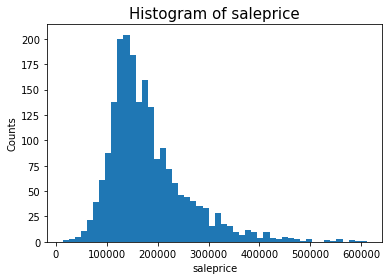

In [863]:
plt.hist(train['saleprice'], bins=50) 
plt.ylabel('Counts')
plt.xlabel('saleprice') # saleprice is reasonably normal
plt.title('Histogram of saleprice', fontsize=15);

In [864]:
# Function to explore numeric variables

def plot_cor(columns):
    var=list(columns)
    var.append('saleprice')
    corr_series = train[var].corr().unstack() 
    corr_series = corr_series[corr_series != 1] # remove corr = 1, ie correlate with itself
    corr_sorted = corr_series['saleprice'].sort_values()  # sort series of correlations
    print(corr_sorted)
    scat = sns.pairplot(data=train,
                        y_vars=['saleprice'],
                        x_vars=train[columns])
    scat.fig.subplots_adjust(top=.8)
    scat.fig.set_size_inches(15,4)
    scat.fig.suptitle('Scatterplot of saleprice and predictors', fontsize = 20)


In [865]:
# An idea of the numeric columns
num_col

Index(['lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'house_age',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'totrms_abvgrd', 'fireplaces', 'garage_age', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       '3ssn_porch', 'screen_porch', 'pool', 'misc_val', 'yr_sold',
       'saleprice'],
      dtype='object')

house_age        -0.571849
overall_cond     -0.097019
lot_frontage      0.181456
lot_area          0.296566
year_remod/add    0.550370
overall_qual      0.800207
dtype: float64


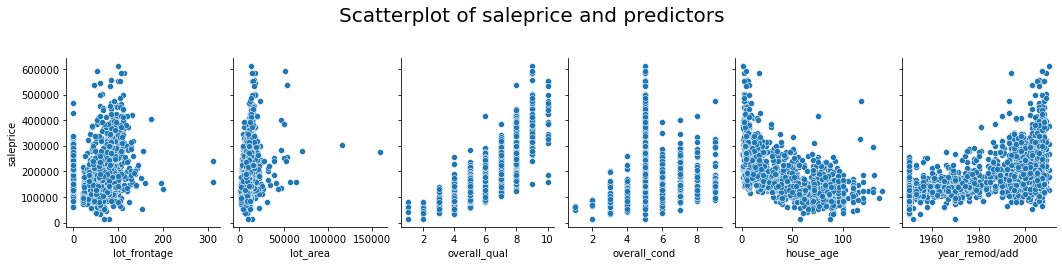

In [866]:
# explore numeric variables 0:6
plot_cor(num_col[:6]) # all have reasonable correlation and trend
                      # further investigate overall_cond
                      # lot_area appears congested at beginning of axis

In [867]:
# view overall_cond
count_mean('overall_cond') # option 5 is overused.
                           # if not, then the scale is very linear
                           # to convert to an ordinal feature with some groupings


              size           mean
overall_cond                     
1                4   59625.000000
2                6   65364.833333
3               35   99786.000000
4               70  114034.571429
6              368  148952.665761
7              270  155327.270370
8              101  155913.366337
9               29  198177.586207
5             1168  207055.988870


In [868]:
def conto_ord(category):
    if type(category) != str:
        if category < 3:
            return 'poor'
        if category < 5:
            return 'fair'
        elif category == 5:
            return 'avg'
        elif category < 9:
            return 'good'
        elif category == 9:
            return 'ex'
        else:
            return np.nan
    else:
        return category

In [869]:
train['overall_cond'] = train['overall_cond'].map(conto_ord)

              saleprice  lot_area_log  lot_area
saleprice      1.000000      0.366678  0.296566
lot_area_log   0.366678      1.000000  0.773592
lot_area       0.296566      0.773592  1.000000


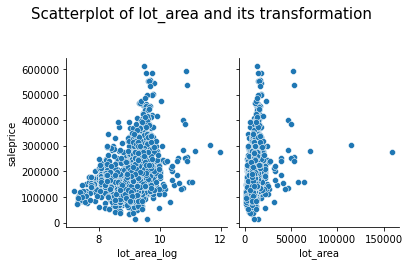

In [870]:
# transformation of lot_area
train['lot_area_log']=np.log(train['lot_area'])
print(train[['saleprice','lot_area_log','lot_area']].corr())

lot_plot = sns.pairplot(data=train, y_vars=['saleprice'], x_vars=['lot_area_log','lot_area'])
                            # lot_area_log has a better linear trend
                            # and better correlation
lot_plot.fig.subplots_adjust(top=.8)
lot_plot.fig.set_size_inches(6,4)
lot_plot.fig.suptitle('Scatterplot of lot_area and its transformation', fontsize =15)
        
drop_list = ['lot_area'] # include lot_area to drop list

In [871]:
# remove outliers as seen in lot_area

# appear to have two clear outliers of very large property
train = train.loc[train['lot_area']<100000,:] # remove 2 lot_area outliers

bsmtfin_sf_2     0.016835
bsmt_unf_sf      0.191051
bsmtfin_sf_1     0.422993
mas_vnr_area     0.502525
1st_flr_sf       0.617896
total_bsmt_sf    0.628782
dtype: float64


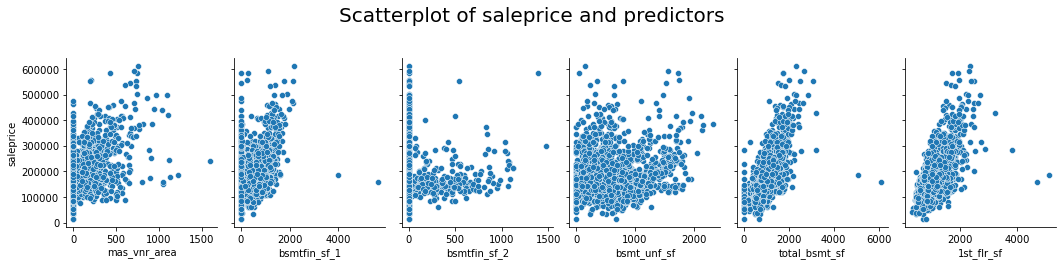

In [872]:
# explore numeric variables 6:12
plot_cor(num_col[6:12]) # all have reasonable correlation and trend
                        # bsmt_sf appear to have outliers
                        # further investigate overall_cond

In [873]:
train = train.loc[train['total_bsmt_sf']<4000,:] # remove 2 total_bsmt_sf outliers
train.shape

(2047, 72)

In [874]:
# add bsmtfin_sf_2' to drop_list
# as it has a poor linear trend and correlation

drop_list.append('bsmtfin_sf_2')

low_qual_fin_sf   -0.041503
2nd_flr_sf         0.249199
gr_liv_area        0.719230
dtype: float64


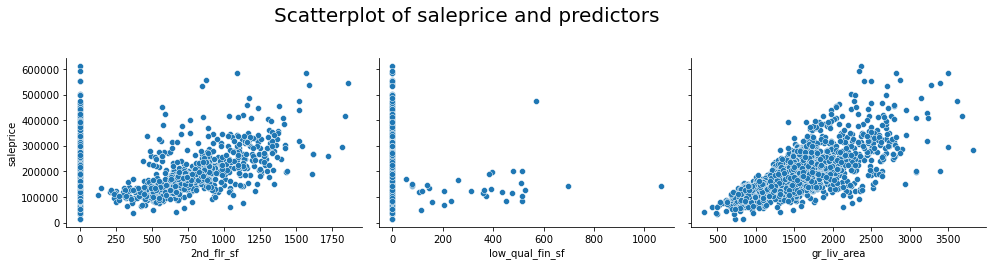

In [875]:
# explore numeric variables 12:15
plot_cor(num_col[12:15]) # low_qual_fin_sf has few counts, poor corr and no trend, to drop

In [876]:
# add low_qual_fin_sf to drop list
drop_list.append('low_qual_fin_sf')

bsmt_half_bath   -0.047754
bsmt_full_bath    0.284488
half_bath         0.284694
full_bath         0.537850
dtype: float64


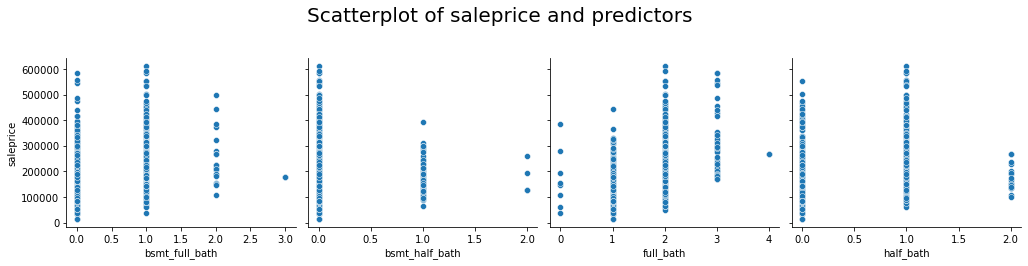

In [877]:
# explore numeric variables 15:19
plot_cor(num_col[15:19])

In [878]:
# explore bath variables
count_mean('bsmt_full_bath')
count_mean('bsmt_half_bath')
count_mean('full_bath')
count_mean('half_bath')
                                # ranking for all bath variables appear to be off
                                # Do not follow a logical order or trend
                                # to drop all bath variables.


                size           mean
bsmt_full_bath                     
0.0             1201  162536.485429
3.0                2  179000.000000
1.0              822  207139.812652
2.0               22  247193.772727
                size           mean
bsmt_half_bath                     
1.0              120  165503.450000
2.0                4  177300.250000
0.0             1923  182372.279251
           size           mean
full_bath                     
1           900  134870.961111
0             8  170226.000000
2          1092  214541.596154
4             2  269500.000000
3            45  304609.155556
           size           mean
half_bath                     
0          1306  163559.251149
2            18  173912.388889
1           723  213738.178423


In [879]:
# add 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath' and 'half_bath' to drop_list
drop_list.extend(['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'])

garage_age      -0.566310
kitchen_abvgr   -0.125318
bedroom_abvgr    0.137307
fireplaces       0.472400
totrms_abvgrd    0.510838
dtype: float64


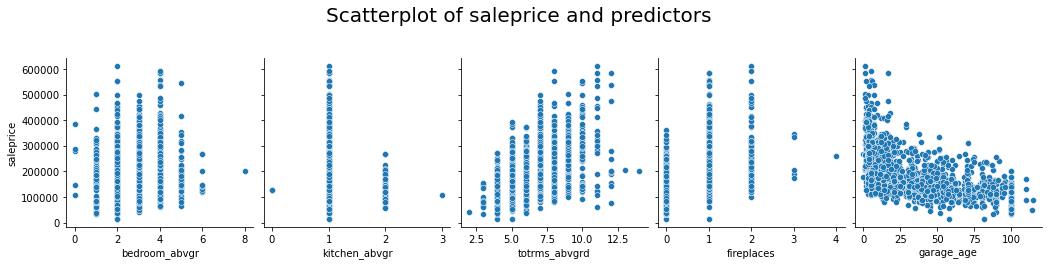

In [880]:
# explore numeric variables 18:24
plot_cor(num_col[19:24])

In [881]:
# 'bedroom_abvgr'
count_mean('bedroom_abvgr') # ranks do not make sense
                            # to drop especially since there is another similar variable

               size           mean
bedroom_abvgr                     
6                12  164111.333333
2               542  164367.787823
3              1107  180645.943089
1                75  182388.920000
8                 1  200000.000000
5                41  203885.951220
4               264  215141.363636
0                 5  240791.800000


In [882]:
# 'kitchen_abvgr'
count_mean('kitchen_abvgr') # has poor correlation and trend
                            # to drop

               size           mean
kitchen_abvgr                     
3                 1  106000.000000
0                 2  127500.000000
2                88  133367.886364
1              1956  183626.857873


In [883]:
drop_list.extend(['kitchen_abvgr', 'bedroom_abvgr'])

enclosed_porch   -0.135344
3ssn_porch        0.048903
wood_deck_sf      0.327141
open_porch_sf     0.338443
garage_cars       0.648459
garage_area       0.655278
dtype: float64


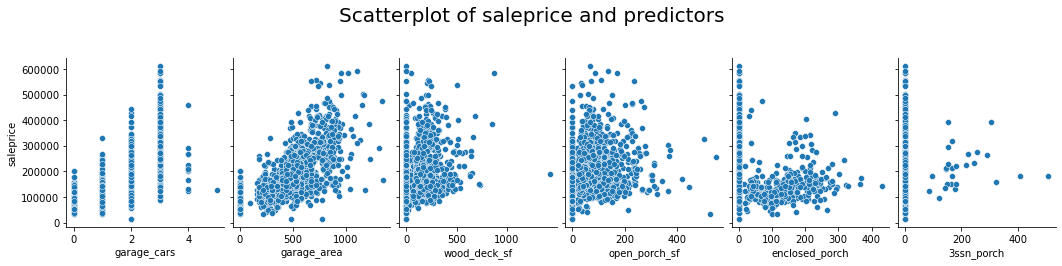

In [884]:
# explore numeric variables 18:24
plot_cor(num_col[24:30])

In [885]:
# add 'enclosed_porch' and '3ssn_porch' to drop_list
# enclosed_porch' and '3ssn_porch' have poor correlation and linear trend
drop_list.extend(['enclosed_porch', '3ssn_porch'])

yr_sold        -0.014402
yr_sold        -0.014402
misc_val       -0.010881
misc_val       -0.010881
pool            0.028060
pool            0.028060
screen_porch    0.135068
screen_porch    0.135068
dtype: float64


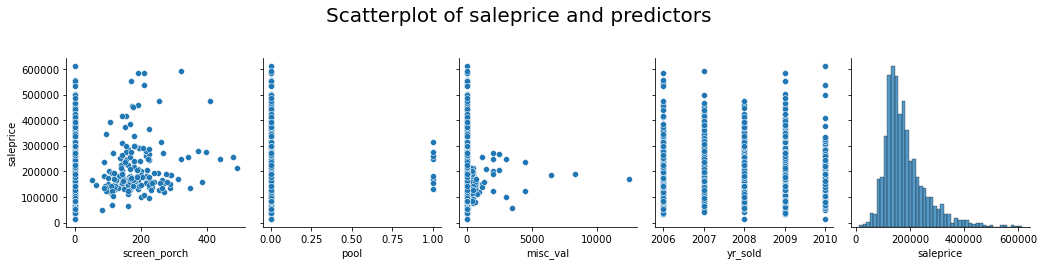

In [886]:
# explore numeric variables 30:
plot_cor(num_col[30:])

In [887]:
# pool is actually binary
count_mean('pool') # small counts in homes with pool and small differences in saleprice
                    # to drop

      size          mean
pool                    
0     2039  181234.20206
1        8  216871.25000


In [888]:
# add 'yr_sold', 'misc_val' and 'screen_porch' to drop_list
# variables have poor correlation and linear trend
drop_list.extend(['screen_porch', 'yr_sold', 'misc_val', 'pool'])

In [889]:
drop_list

['lot_area',
 'bsmtfin_sf_2',
 'low_qual_fin_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'kitchen_abvgr',
 'bedroom_abvgr',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'yr_sold',
 'misc_val',
 'pool']

In [890]:
# drop variables in droplist
train.drop(drop_list, axis=1, inplace=True)

# number of features
print(train.select_dtypes([np.number]).shape)
print(train.shape)

(2047, 29)
(2047, 57)


### Remarks
**Continuous features data cleaning**

All continuous features were within their range if it was prescribed.

Lot area was log transformed, which improved its correlation with saleprice.

Some outliers were spotted, probably from very large houses which is uncommon. These datapoints were removed from the sample.

Certain varaibles had very little useful counts within the feature causing the bulk of the data to be at 0. For example low_qual_sq_fin were mostly 0, likely cause few homes had low quality finished areas in their homes. Such variables were dropped.

bsmt_full_bath, bsmt_half_bath, full_bath and half_bath features are in between continuous and categorical features. Nonetheless they did not appear to have a relationship with saleprice and were dropped.

### Remarks
**After data cleaning and eda**

The dataset provides numerous features which is largely clean and usable. Features which have been deemed important during background research are available in the dataset, and simple correlations have revealed multiple variables with high correlations with the outcome of interest, saleprice.<br/>

It is likely that a reasonable model can be built fromt he existing data which can predict saleprice.

### Assessing Correlations between predictors

Check and remove variables which are highly correlated, and conceptually similar.

In [891]:
# Reference list of highly correlated variables
# If they are set to 0 by lasso later on, can check if they are represented by a similar variable

# Examine highly correlated variables 
# to weed out possible multicollinear variables
corr_abs = train.select_dtypes([np.number]).corr().abs() # get absolute correlations
corr_series = corr_abs.unstack()                         # convert df to series
corr_sorted = corr_series.sort_values(ascending=False)   # sort series of correlations
corr_sorted = corr_sorted[corr_sorted != 1]              # remove corr = 1, ie correlate with itself
corr_sorted[:20]

garage_area    garage_cars      0.897597
garage_cars    garage_area      0.897597
fireplace_qu   fireplaces       0.861572
fireplaces     fireplace_qu     0.861572
totrms_abvgrd  gr_liv_area      0.812835
gr_liv_area    totrms_abvgrd    0.812835
overall_qual   saleprice        0.803859
saleprice      overall_qual     0.803859
1st_flr_sf     total_bsmt_sf    0.789959
total_bsmt_sf  1st_flr_sf       0.789959
garage_age     house_age        0.788174
house_age      garage_age       0.788174
exter_qual     overall_qual     0.738963
overall_qual   exter_qual       0.738963
kitchen_qual   exter_qual       0.729390
exter_qual     kitchen_qual     0.729390
gr_liv_area    saleprice        0.719230
saleprice      gr_liv_area      0.719230
garage_cars    garage_age       0.716402
garage_age     garage_cars      0.716402
dtype: float64

In [892]:
# for vairables which are highly correlated (r > 0.8), and are logically related, to only use one
# remove garage_cars
# remove totrms_abvgrd

train.drop(['garage_cars', 'totrms_abvgrd'], axis=1, inplace=True)

### Data cleaning for Kaggle Upload

In [893]:
# test data cleaning and transformation
test_or = pd.read_csv('datasets/test.csv')
test = pd.read_csv('datasets/test.csv')

new_col_names = [x.replace(" ", "_").lower() for x in list(test.columns)]
test.columns = new_col_names

test.drop('pool_qc', axis = 1, inplace = True)  
test['pool_area'] = [ x if x == 0 else 1 for x in test['pool_area']]
test.rename(columns={"pool_area": "pool"}, inplace=True)

test.drop('misc_feature', axis=1, inplace=True)
test['alley'].fillna('no_alley', inplace=True)
test['fence'].fillna('no_fence', inplace=True)
test['fireplace_qu'].fillna('non', inplace=True)


test.fillna({
    'mas_vnr_type' : 'non',
    'mas_vnr_area' : 0,  
}, inplace=True)

test['lot_frontage'].fillna(0, inplace=True)

test['garage_yr_blt'] = test['garage_yr_blt'].fillna(1910)
           
test.loc[(test['garage_area'].isnull()) & 
          (test['garage_type'] == 'Detchd'), 'garage_type'] = np.nan
           
test.fillna({
    'garage_type':'non',
    'garage_finish':'non',
    'garage_qual':'non',
    'garage_cond':'non',
    'garage_cars' : 0,
    'garage_area' : 0
}, inplace=True)


test.fillna({
    'bsmt_qual':'non',
    'bsmt_cond':'non',
    'bsmt_exposure':'non',
    'bsmtfin_type_1':'non',
    'bsmtfin_sf_1' : 0,
    'bsmtfin_type_2' : 'non',
    'bsmtfin_sf_2' : 0,
    'bsmt_unf_sf' : 0,
    'total_bsmt_sf' : 0,
    'bsmt_full_bath' : 0,
    'bsmt_half_bath' : 0,  
}, inplace=True)

test['garage_yr_blt'] = 2010 - test['garage_yr_blt']
test['year_built'] = 2010 - test['year_built']

test.rename(columns={"garage_yr_blt": "garage_age", "year_built": "house_age"}, inplace=True)

test.drop(['pid', 'id'], axis=1, inplace=True)
test['ms_subclass'] = test['ms_subclass'].astype(str)
test['mo_sold'] = test['mo_sold'].astype(str)

test['ms_zoning']=['a_c_i' if x in ['A (agr)', 'I (all)', 'C (all)'] else x for x in test['ms_zoning']]
test.drop('lot_shape', axis = 1, inplace=True)
test.drop('utilities', axis=1, inplace=True)
test.drop('land_slope', axis=1, inplace=True)

test['exter_qual'] = test['exter_qual'].map(ordto_con)
test.drop('exter_cond', axis = 1, inplace=True)
test['bsmt_qual'] = test['bsmt_qual'].map(ordto_con)
test['bsmt_cond'] = test['bsmt_cond'].map(ordto_con)

test['bsmt_exposure'] = test['bsmt_exposure'].map(ordto_con2)
test['bsmtfin_type_1'] = test['bsmtfin_type_1'].map(bsmt_categorise)
test['bsmtfin_type_2'] = test['bsmtfin_type_2'].map(bsmt_categorise)

test['heating_qc'] = test['heating_qc'].map(ordto_con)

test['electrical'] = ['FuseP_Mix' if x in ['FuseP', 'Mix'] else x for x in test['electrical']]
test['kitchen_qual'] = test['kitchen_qual'].map(ordto_con)
test.drop('functional', axis=1, inplace=True)
test['fireplace_qu'] = test['fireplace_qu'].map(ordto_con)

test.drop('garage_cond', axis=1, inplace=True)
test['garage_qual'] = test['garage_qual'].map(ordto_con)
test['garage_finish'] = test['garage_finish'].map(garage_fin_con)

test['lot_area_log']=np.log(test['lot_area'])

test['overall_cond'] = test['overall_cond'].map(conto_ord)
test.drop(drop_list, axis=1, inplace=True)

test.drop(['garage_cars', 'totrms_abvgrd'], axis=1, inplace=True)

In [894]:
train.select_dtypes([np.number]).columns

Index(['lot_frontage', 'overall_qual', 'house_age', 'year_remod/add',
       'mas_vnr_area', 'exter_qual', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_sf_1', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating_qc',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'kitchen_qual', 'fireplaces',
       'fireplace_qu', 'garage_age', 'garage_finish', 'garage_area',
       'garage_qual', 'wood_deck_sf', 'open_porch_sf', 'saleprice',
       'lot_area_log'],
      dtype='object')

In [895]:
train.select_dtypes(include='object').columns

Index(['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour',
       'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_cond', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'central_air',
       'electrical', 'garage_type', 'paved_drive', 'fence', 'mo_sold',
       'sale_type'],
      dtype='object')

# Model Building

Model building will be performed in a step-wise fashion where a predetermined set of variables will be added after each step. Each model will be evaluated and poorly performing features will be considered to be dropped.<br/>

Model 1: To include variables supported by background research<br/>
Model 2: To add the remaining continuous variables<br/>
Model 3: To add the remaining categorical variables<br/>
Model 4: Polynomial features<br/>

**Functions are created below to print out key information for the models built.**

In [896]:
# Function to check that the best alpha does not hit a ceiling

def check_alphas():
    print(lasso_cv.alpha_)
    print(ridge_cv.alpha_)
    print(enet_cv.alpha_)

In [897]:
# Function to get the cross validated neg_mean_squared_error for all variables

def get_cross_val(model_no):
    print(f' Model {model_no} linear regression cross_val nmse is {lr_cross:.0f}')
    print(f' Model {model_no} lasso regression cross_val nmse is {lasso_cross:.0f}')
    print(f' Model {model_no} ridge regression cross_val nmse is {ridge_cross:.0f}')
    print(f' Model {model_no} enet regression cross_val nmse is {enet_cross:.0f}')

In [898]:
# Function to get mean squared error and root mean squared error for all models

def error_scores(model_no):
    print(f' Model {model_no} linear regression mse={lr_mse:.0f}, rmse ={(lr_mse**0.5):.0f}')
    print(f' Model {model_no} ridge regression mse={ridge_mse:.0f}, rmse ={(ridge_mse**0.5):.0f}')
    print(f' Model {model_no} lasso regression mse={lasso_mse:.0f}, rmse ={(lasso_mse**0.5):.0f}')
    print(f' Model {model_no} enet regression mse={enet_mse:.0f}, rmse ={(enet_mse**0.5):.0f}')

### Build Base Model (Model 1)

Variables highlighted as important based on background research was used to build the base model. This included variables related to:
1. Location, neighborhood, nearby features
2. Home size, layout
3. Home age
4. Property condition

In [899]:
# Feature Selection
features = ['lot_frontage', 'overall_qual', 'exter_qual', # numeric features first
           'house_age', 'bsmt_qual', 'bsmt_cond', 'total_bsmt_sf',
           'gr_liv_area', 'kitchen_qual', 'garage_age',
           'garage_area', 'garage_qual', 'lot_area_log']

cat_features = ['ms_zoning', 'neighborhood',
                'condition_1', 'condition_2']

features.extend(cat_features)
X_1 = train[features]


In [900]:
# Get_dummies
# to get_dummies together with kaggle test set

test_data = test[features]            # test data
X_1_test_data = pd.concat([X_1, test_data])
X_1_test_data = pd.get_dummies(data=X_1_test_data, drop_first=True)


In [901]:
# Define X and y
X = X_1_test_data.iloc[:train.shape[0],:]
y = train['saleprice']

In [902]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

# Standardisation
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [903]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(.0001, 150, 200))
enet_cv = ElasticNetCV(alphas=np.linspace(.0001, 150, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1245336700.3963623, tolerance: 794348290.3029631
  model = cd_fast.enet_coordinate_descent_gram(


264.34487557598845
55.02518894472362
0.15025005005005004


In [904]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('1')

 Model 1 linear regression cross_val nmse is -34551065752290509502484108441288704
 Model 1 lasso regression cross_val nmse is -805368827
 Model 1 ridge regression cross_val nmse is -808781319
 Model 1 enet regression cross_val nmse is -810766089


In [905]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('1')

 Model 1 linear regression mse=637711730, rmse =25253
 Model 1 ridge regression mse=646263292, rmse =25422
 Model 1 lasso regression mse=653938270, rmse =25572
 Model 1 enet regression mse=647986394, rmse =25456


### Assessing features in the Base Model (Model 1)

Use Lasso Regression coefficients to identify variables which will be heavily penalised.


In [906]:
# Find weak variables
lasso_coef = pd.DataFrame(data=lasso_best.coef_,
                          index=Z_train.columns,
                          columns=['coef'])

lasso_0 = lasso_coef.loc[lasso_coef['coef'] == 0, :]
lasso_0.shape

(17, 1)

In [907]:
# to view the variables with 0 coef
#lasso_0

### Review
**Base Model (Model 1)**<br/>
Absolute mean sqaure error of the train set cross_val_score is similar to the test set. Hence there is little evidence of overfitting.<br/>
Several coefficients relating to location were penalised to 0, this is likely because there are too many categories and there are likely to be little differences betweent them. <br/>

garage_qual is set to 0, likely due to because it does not have an ideal ordering between its different ranks. Furthermore the middle rank (3) seems to be overused, leaving few counts in the other categories. <br/>

As these are core variables they will be retained for now.

**Comparison across regression models**<br/>
Ridge and enet is very similar while lasso is about 200 points poorer on rmse.

In [908]:
# run code here to see garage_qual counts
# count_mean('garage_qual') # note that mean represents mean saleprice

### Model 2

Model 2 has will retain all variables included in model 1, and include the remaining continuous variables.

In [909]:
# Feature Selection
features = list(train.select_dtypes([np.number]).columns)
features.remove('saleprice')

cat_features = ['ms_zoning', 'neighborhood',
                'condition_1', 'condition_2']
features.extend(cat_features)
X_2 = train[features]


In [910]:
# Get_dummies
# to get_dummies together with test set

test_data = test[features]            # test data
X_2_test_data = pd.concat([X_2, test_data])
X_2_test_data = pd.get_dummies(data=X_2_test_data, drop_first=True)


In [911]:
# Define X and y
X = X_2_test_data.iloc[:train.shape[0],:]
y = train['saleprice']

In [912]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [913]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(.0001, 150, 200))
enet_cv = ElasticNetCV(alphas=np.linspace(.0001, 150, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349431904596.7228, tolerance: 795172030.6508095
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317761501058.6778, tolerance: 817786887.7724217
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138777959221.84674, tolerance: 779874152.314126
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinat

257.00485206093185
88.94476432160803
0.15025005005005004


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3694772758.977539, tolerance: 755954118.8755153
  model = cd_fast.enet_coordinate_descent_gram(


In [914]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('2')


 Model 2 linear regression cross_val nmse is -68316498447304011753972613964103680
 Model 2 lasso regression cross_val nmse is -700363957
 Model 2 ridge regression cross_val nmse is -696962681
 Model 2 enet regression cross_val nmse is -697085119


In [916]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('2')

 Model 2 linear regression mse=451816758, rmse =21256
 Model 2 ridge regression mse=458829638, rmse =21420
 Model 2 lasso regression mse=475094255, rmse =21797
 Model 2 enet regression mse=459304495, rmse =21431


### Identify poorly performing features in model 2
Use Lasso Regression to identify variables which will be heavily penalised

In [917]:
# Find weak variables
lasso_coef = pd.DataFrame(data=lasso_best.coef_,
                          index=Z_train.columns,
                          columns=['coef'])

lasso_0 = lasso_coef.loc[lasso_coef['coef'] == 0, :]
lasso_0.shape

(19, 1)

In [918]:
# to view the variables with 0 coef
# lasso_0

**Model 2**<br/>
RMSE of the train set is similar to the test set. Hence there is little evidence of overfitting. Once again several locations have emerged, likely due to lower counts. Since they are base variables, they will be retained. <br/>

Several other heavily penalised features have emerged. In particular, garage_qual has appeared again.
Decisions for the variables are below, while the others will be kiv.

**Comparison across regression models**<br/>
Once again, Ridge and enet is very similar while lasso is about 200 points poorer on rmse.

***Comparison with previous models***<br/>
RMSE has improved from model 1.<br/>
Model 1 rmse~ 27,000<br/>
Model 2 rmse~ 24,000<br/>

In [919]:
corr_sorted['1st_flr_sf'] # r = 0.79 with total_bsmt_sf
                          # r = 0.65 with saleprice

corr_sorted['2nd_flr_sf'] # r = 0.66 with gr_liv_area 
                          # r = 0.25 with saleprice
                          # since there is a similar variables and low corr with saleprice
                          # to drop
        
corr_sorted['garage_age'] # r = 0.79 with house_age
                          # r = 0.57 with saleprice

corr_sorted['garage_qual']# r = 0.61 with garage_age
                          # r = 0.29 with saleprice
                          # since there is a similar variables and low corr with saleprice
                          # to drop
    
corr_sorted['bsmt_unf_sf']# r = 0.44 with total_bsmt_sf
                          # r = 0.19 with saleprice

bsmtfin_sf_1      0.499543
total_bsmt_sf     0.439363
1st_flr_sf        0.312271
overall_qual      0.276450
totrms_abvgrd     0.256727
exter_qual        0.240727
gr_liv_area       0.239225
bsmt_qual         0.229245
saleprice         0.191072
kitchen_qual      0.184799
heating_qc        0.173751
garage_cars       0.168143
bsmt_cond         0.166804
year_remod/add    0.160536
lot_frontage      0.149681
garage_area       0.146112
garage_age        0.143808
house_age         0.136810
open_porch_sf     0.114594
fireplace_qu      0.102968
garage_finish     0.094441
lot_area_log      0.091068
mas_vnr_area      0.081299
wood_deck_sf      0.035542
bsmt_exposure     0.026731
garage_qual       0.013994
2nd_flr_sf        0.012148
fireplaces        0.001485
dtype: float64

In [920]:
to_drop = ['2nd_flr_sf', 'garage_qual']

## Model 3

Model 3 has will retain all variables included in model 1, and include the remaining categorical variables.

In [921]:
# Feature Selection
to_drop.append('saleprice')

features = [x for x in list(train.columns) if x not in to_drop]
features

X_3 = train[features]

In [922]:
# Get_dummies
# to get_dummies together with test set

test_data = test[features]            # test data
X_3_test_data = pd.concat([X_3, test_data])
X_3_test_data = pd.get_dummies(data=X_3_test_data, drop_first=True)

In [923]:
# Define X and y
X = X_3_test_data.iloc[:train.shape[0],:]
y = train['saleprice']

In [924]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

# Standardisation
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [925]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(.0001, 150, 200))
enet_cv = ElasticNetCV(alphas=np.linspace(.0001, 150, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254771815588.44913, tolerance: 746508577.8464361
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255455682875.00922, tolerance: 731727745.0060744
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241257166066.46747, tolerance: 709575109.4290518
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordi

528.1522440689399
150.0
0.45055015015015015


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262990582022.9846, tolerance: 762090972.4544567
  model = cd_fast.enet_coordinate_descent_gram(


In [926]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('3')


 Model 3 linear regression cross_val nmse is -191907898267313146839617564049408
 Model 3 lasso regression cross_val nmse is -600209920
 Model 3 ridge regression cross_val nmse is -626362308
 Model 3 enet regression cross_val nmse is -623222991


In [927]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('3')

 Model 3 linear regression mse=310959988, rmse =17634
 Model 3 ridge regression mse=389371445, rmse =19732
 Model 3 lasso regression mse=406806682, rmse =20169
 Model 3 enet regression mse=388523304, rmse =19711


### Identify poorly performing features in model 3
Use Lasso Regression to identify variables which will be heavily penalised


In [928]:
# Find weak variables
lasso_coef = pd.DataFrame(data=lasso_best.coef_,
                          index=Z_train.columns,
                          columns=['coef'])

lasso_0 = lasso_coef.loc[lasso_coef['coef'] == 0, :]
lasso_0.shape

(113, 1)

In [929]:
# to view the variables with 0 coef
# lasso_0

### Review

**Model 3**<br/>
RMSE of the train set is similar to the test set. Hence there is little evidence of overfitting.<br/>

Numerous variables were heavily penalised. 
Continuous variables that were previously flagged in step 2, flagged in step 3 but are not part of the base model were removed. Continuous features removed:
1. bsmt_unf_sf

Categorical variables were checked further checked through the previously created function 'count_mean' to see the proportions in each category and the differences in the mean saleprice for each category. If these variables had small counts in each category, small differences in mean saleprice and had most of its category coefficients set to 0 (e.g. sale_type has 6 of 8 categories set to 0), the category will be removed. Categorical features removed:
1. street
2. alley
3. house_style
4. roof_style
5. exterior_1st
6. exterior_2nd
7. mas_vnr_type
8. foundation
9. central_air
10. electrical
11. garage_type
12. mo_sold
13. sale_type

**Comparison across regression models**<br/>
Once again, Ridge and enet is very similar while lasso is about 300 points poorer on rmse.

***Comparison***<br/>
RMSE has improved from model 2.<br/>
Model 1 rmse~ 27,000<br/>
Model 2 rmse~ 24,000<br/>
Model 3 rmse~ 22,000<br/>

To assess if dropping the above variables will have a negative impact on the model, model 3I will be fit.

### Model 3I
Check if mode improved/maintain after dropping the abovementioned variables

In [930]:
to_drop.extend(['bsmt_unf_sf', 'street', 'alley',
                 'house_style', 'roof_style', 'exterior_1st', 'exterior_2nd',
                 'mas_vnr_type', 'foundation', 'central_air', 'electrical',
                 'garage_type', 'mo_sold', 'sale_type'])

In [931]:
features = [x for x in list(train.columns) if x not in to_drop]
features

X_3I = train[features]

In [932]:
# Get_dummies
# to get_dummies together with test set

test_data = test[features]            # test data
X_3I_test_data = pd.concat([X_3I, test_data])
X_3I_test_data = pd.get_dummies(data=X_3I_test_data, drop_first=True)

In [933]:
X_3I_test_data.shape

(2925, 120)

In [934]:
# Define X and y
X = X_3I_test_data.iloc[:train.shape[0],:]
y = train['saleprice']

In [935]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

# Standardisation
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [936]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(.0001, 150, 200))
enet_cv = ElasticNetCV(alphas=np.linspace(.0001, 150, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326033718953.4163, tolerance: 784994022.4983708
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310075367625.987, tolerance: 788548183.4803774
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321500225947.221, tolerance: 774372197.8964036
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_

73.75683434751323
33.91967537688442
0.15025005005005004


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311535283354.6182, tolerance: 765028873.6243528
  model = cd_fast.enet_coordinate_descent_gram(


In [937]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('3I')


 Model 3I linear regression cross_val nmse is -77078799074612115619849789505536
 Model 3I lasso regression cross_val nmse is -638850708
 Model 3I ridge regression cross_val nmse is -637329913
 Model 3I enet regression cross_val nmse is -639239535


In [938]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('3I')

 Model 3I linear regression mse=373587990, rmse =19328
 Model 3I ridge regression mse=376595134, rmse =19406
 Model 3I lasso regression mse=396970846, rmse =19924
 Model 3I enet regression mse=400102543, rmse =20003


**Model 3I**<br/>

RMSE of the train set is similar to the test set. Hence there is little evidence of overfitting.<br/>


**Comparison***<br/>
RMSE has improved from model 3.<br/>
Model 1 rmse~ 27,000<br/>
Model 2 rmse~ 24,000<br/>
Model 3 rmse~ 22,000<br/>
Model 3I rmse~ 21,000<br/>

Since rmse did not drop from model 3, the dropped features were likely not important to predict saleprice.

### Model 4

Model 3 has will retain all variables included in model 3I and add on selected polynomial features.

**Exploration of potential polynomial features***

In [939]:
# Polynomial transformation
X_pol = train.select_dtypes([np.number]).copy()
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X_pol)

pol_df = pd.DataFrame(X_poly, # convert polynomial transformation into df
                      columns=poly.get_feature_names(X_pol.columns))

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [940]:
# To get a table of correlations
poly_sale = pol_df.corr()[['saleprice']]
nonsale_col = [x for x in list(poly_sale.index) if 'saleprice' not in x]

poly_sale['saleprice_abs'] = poly_sale['saleprice'].abs()

In [941]:
# Top 20 variables have been flagged for polynomial fitting
top_20_poly = poly_sale.loc[nonsale_col,].sort_values('saleprice_abs',ascending = False).head(20)

top_20_poly = list(top_20_poly.index)

In [942]:
# Extract individual features which are in top_20_poly

each_poly_v = []
for feat in top_20_poly:
    two_v = feat.split()
    each_poly_v.extend(two_v)

# creat list of top_20_poly with different order as they get mixed up later
comb_poly_v = []
for feat in top_20_poly:
    two_v = feat.split()
    if len(two_v) == 2:
        reverse_v = two_v[1] + ' ' + two_v[0]
    comb_poly_v.append(reverse_v)
    comb_poly_v.append(feat)

# get unique features in each_poly_v
poly_set = set(each_poly_v)
ind_poly_feat = list(poly_set)

# remove extra var and add reference index 
ind_poly_feat.remove('overall_qual^2')
ind_poly_feat.append('ref')

**Creating and adding selected polynomial features**

In [943]:
X_3I = train[features].copy()
test_3I = test[features].copy() # adding in to get polynomials together
X_test_3I = pd.concat([X_3I, test_3I])
X_test_3I ['ref']=list(range(0,2925))

In [944]:
# Polynomial transformation
X_pol = X_test_3I [ind_poly_feat].copy()
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X_pol)

pol_pd = pd.DataFrame(X_poly, # convert polynomial transformation into df
                      columns=poly.get_feature_names(X_pol.columns))

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [945]:
# list of polynomials
pol_pd_varlist = []
for var in comb_poly_v:
    if var in list(pol_pd.columns):
        pol_pd_varlist.append(var)
        
# add reference
pol_pd_varlist.append('ref')

In [948]:
poly_features = pol_pd[pol_pd_varlist]

**Model 4**

In [949]:
X_4_poly = pd.merge(X_test_3I, poly_features, on=['overall_qual', 'ref'])

In [950]:
# Get_dummies
# to get_dummies together with test set

X_4_test_data= pd.get_dummies(data=X_4_poly, drop_first=True)

In [951]:
# Define X and y
X = X_4_test_data.loc[X_4_test_data['ref']<train.shape[0],:].copy()
X.drop('ref', inplace=True, axis=1)
y = train['saleprice']

In [952]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

# Standardisation
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [953]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(.0001, 150, 200))
enet_cv = ElasticNetCV(alphas=np.linspace(.00001, 150, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e+10, tolerance: 9.672e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200342907501.95227, tolerance: 772771698.8337865
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191809011156.64288, tolerance: 772771698.8337865
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\d

69.84099474672522
5.276478391959799
1e-05


In [954]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('4')

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+10, tolerance: 7.728e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+10, tolerance: 7.739e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.43

 Model 4 linear regression cross_val nmse is -23517795915831561845604209393664
 Model 4 lasso regression cross_val nmse is -432127379
 Model 4 ridge regression cross_val nmse is -432653400
 Model 4 enet regression cross_val nmse is -437254544


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+11, tolerance: 7.943e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e+11, tolerance: 7.915e+08
  model = cd_fast.enet_coordinate_descent(


In [955]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('4')

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+10, tolerance: 3.174e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.278e+10, tolerance: 3.174e+08
  model = cd_fast.enet_coordinate_descent(


 Model 4 linear regression mse=321013369, rmse =17917
 Model 4 ridge regression mse=345677340, rmse =18592
 Model 4 lasso regression mse=351158339, rmse =18739
 Model 4 enet regression mse=323195270, rmse =17978


In [956]:
# Find weak variables
lasso_coef = pd.DataFrame(data=lasso_best.coef_,
                          index=Z_train.columns,
                          columns=['coef'])

lasso_0 = lasso_coef.loc[lasso_coef['coef'] == 0, :]
lasso_0.shape

(31, 1)

In [669]:
# unhash to view
# lasso_0

### Review

**Model 4**<br/>
RMSE of the train set is similar to the test set. Hence there is little evidence of overfitting.<br/>

Numerous variables were heavily penalised. Since they are fringe variables, they were dropped.
1. roof_matl
2. fence
3. paved_drive

Some interactions were also penalised to coef= 0 in Lasso Regression. It is likely they these were too similar as they were mostly interactions with overall_qual.

1. gr_liv_area overall_qual
2. gr_liv_area bsmt_qual
3. 1st_flr_sf bsmt_qual
4. overall_qual^2
5. bsmt_qual overall_qual
6. year_remod/add overall_qual

**Comparison across regression models**<br/>
In this analysis, enet and linear regression performed the best, with about 600 rmse better than ridge and lasso regression.

***Comparison***<br/>
RMSE has improved from model 2.<br/>
Model 1 rmse~ 27,000<br/>
Model 2 rmse~ 24,000<br/>
Model 3 rmse~ 22,000<br/>
Model 3I rmse~ 21,000<br/>
Model 4 rmse~ 19,000<br/>

To assess if dropping the above variables will have a negative impact on the model, model 4I will be fit.

In [958]:
poly_drop_list = ['gr_liv_area overall_qual', 'gr_liv_area bsmt_qual',
                  '1st_flr_sf bsmt_qual', 'overall_qual^2', 
                  'bsmt_qual overall_qual', 'year_remod/add overall_qual'
                  'roof_matl', 'fence', 'paved_drive']

**Model 4I**

In [959]:
X_4I_test_data = X_4_poly.copy()

poly_features = [x for x in list(X_4I_test_data.columns) if x not in poly_drop_list]
poly_features

X_4I_test_data = X_4I_test_data[poly_features]

In [960]:
# Get_dummies
# to get_dummies together with test set

X_4I_test_data= pd.get_dummies(data=X_4I_test_data, drop_first=True)

In [961]:
# Define X and y
X = X_4I_test_data.loc[X_4I_test_data['ref']<train.shape[0],:].copy()
X.drop('ref', inplace=True, axis=1)

y = train['saleprice']

In [962]:
# Train Test Split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
)

# Standardisation
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_holdout = ss.transform(X_holdout)


Z_train = pd.DataFrame(data=Z_train, columns=X_train.columns)
Z_holdout = pd.DataFrame(data=Z_holdout, columns=X_holdout.columns)

In [963]:
#    1) instantiate linearRegression and the Cross validated models for regularisation

lr = LinearRegression()
lasso_cv = LassoCV(n_alphas=200)
ridge_cv = RidgeCV(alphas=np.linspace(0.001, 200, 1000))
enet_cv = ElasticNetCV(alphas=np.linspace(0.001, 200, 1000), l1_ratio=0.5)

#    2) fit models with the best alpha
lasso_cv.fit(Z_train, y_train)
ridge_cv.fit(Z_train, y_train)
enet_cv.fit(Z_train, y_train)

#    3) check that the best alpha does not hit a ceiling
check_alphas()

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.241e+10, tolerance: 9.625e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24329916270.20453, tolerance: 778080199.8511019
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203668833940.8369, tolerance: 778080199.8511019
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi

67.71828914713277
3.804784784784785
0.001


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11821033336.336304, tolerance: 785279785.3091651
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197712693074.3795, tolerance: 785279785.3091651
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.668e+11, tolerance: 9.625e+08
  model = cd_fast.enet_coordinate_descent(


In [964]:
#    1) instantiate regularised models with the best alpha

lasso_best = Lasso(alpha = lasso_cv.alpha_)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
enet_best = ElasticNet(alpha = enet_cv.alpha_, l1_ratio=0.5)

#    2) get the cross validated neg_mean_squared_error for all variables
lr_cross = cross_val_score(lr, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cross = cross_val_score(lasso_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cross = cross_val_score(ridge_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
enet_cross = cross_val_score(enet_best, Z_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

get_cross_val('4I')

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+10, tolerance: 7.781e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+10, tolerance: 7.945e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.17

 Model 4I linear regression cross_val nmse is -590890542367205315127453679616
 Model 4I lasso regression cross_val nmse is -447529493
 Model 4I ridge regression cross_val nmse is -443806760
 Model 4I enet regression cross_val nmse is -444247841


C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+11, tolerance: 7.122e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+11, tolerance: 7.853e+08
  model = cd_fast.enet_coordinate_descent(


In [965]:
#    1) fit all models with the holdout test data

lr.fit(Z_holdout, y_holdout)
lasso_best.fit(Z_holdout, y_holdout)
ridge_best.fit(Z_holdout, y_holdout)
enet_best.fit(Z_holdout, y_holdout)

#    2) get mean squared error and root mean squared error for all models
lr_mse = mean_squared_error(y_holdout, lr.predict(Z_holdout))
ridge_mse = mean_squared_error(y_holdout, lasso_best.predict(Z_holdout))
lasso_mse = mean_squared_error(y_holdout, ridge_best.predict(Z_holdout))
enet_mse = mean_squared_error(y_holdout, enet_best.predict(Z_holdout))

error_scores('4I')

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+10, tolerance: 3.225e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.678e+10, tolerance: 3.225e+08
  model = cd_fast.enet_coordinate_descent(


 Model 4I linear regression mse=291257903, rmse =17066
 Model 4I ridge regression mse=305213073, rmse =17470
 Model 4I lasso regression mse=312973869, rmse =17691
 Model 4I enet regression mse=292122042, rmse =17092


### Review

**Model 4I**<br/>
RMSE of the train set is similar to the test set. Hence there is little evidence of overfitting.<br/>

**Comparison across regression models**<br/>
In this analysis, enet and linear regression performed the best, with about 400 rmse better than ridge and lasso regression.

***Comparison***<br/>
RMSE has improved from model 2.<br/>
Model 1 rmse~ 27,000<br/>
Model 2 rmse~ 24,000<br/>
Model 3 rmse~ 22,000<br/>
Model 3I rmse~ 21,000<br/>
Model 4 rmse~ 19,000<br/>
Model 4I rmse~ 17,000<br/>

To assess if dropping the above variables will have a negative impact on the model, model 4I will be fit.

## Conclusions and Recommendations

The models above will be able to predict the saleprice of houses to reasonable accuracy. We would reccomend users to use Model 4I using enet regression to predict sale prices as it has the best accuracy.

If future staff need to develop other models for a price prediction model in other neighborhoods with little time or resources, it is reccomended to start with variables similar to that in the base model (Model 1). This will require the least number of variables for a reasonable model.

In [716]:
#Testing model 1 on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_1_test_data.iloc[2047:,:]

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = enet_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result1.csv', index = False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [679]:
#Testing model 2 on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_2_test_data.iloc[2047:,:]

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = enet_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result2.csv', index = False)

In [ ]:
#Testing model 3 on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_3_test_data.iloc[2047:,:]

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = enet_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result3.csv', index = False)

In [ ]:
#Testing model 3I on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_3I_test_data.iloc[2047:,:]

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = enet_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result3I.csv', index = False)

In [957]:
#Testing model 4 on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_4_test_data.loc[X_4_test_data['ref']>2046,:].sort_values('ref', ascending=True)
kaggle_test.drop('ref', inplace=True, axis=1)

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = enet_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result4.csv', index = False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [720]:
X_4_test_data.loc[X_4_test_data['ref']>2046,:].shape

(878, 142)

In [968]:
#Fitting for model 4I with train + holdout

ss = StandardScaler()
ss.fit(X)
Z = ss.transform(X)
ridge_cv.fit(Z, y)
ridge_best = Ridge(alpha = ridge_cv.alpha_)
ridge_best.fit(Z_holdout, y_holdout)

Ridge(alpha=0.001)

In [969]:
#Testing model 4 on Kaggle
# Pulling out X vars for kaggle_test data

kaggle_test = X_4I_test_data.loc[X_4I_test_data['ref']>2046,:].sort_values('ref', ascending=True)
kaggle_test.drop('ref', inplace=True, axis=1)

# Transform and predict for test set

kaggle_test_sc = ss.transform(kaggle_test)
k = ridge_best.predict(kaggle_test_sc)

# Manipulation for upload to Kaggle

k_up = pd.DataFrame(data=k, columns=['SalePrice'])
k_up['Id']=test_or['Id']
k_up= k_up[['Id','SalePrice' ]]

#Save predicted results to csv
k_up.to_csv('result4I.csv', index = False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [857]:
k.shape
lasso_cv.coef_.shape
X_1_test_data.columns.shape

(59,)